# Tennis Court Discriminator

The logic is similar to Running Track Descriminator.

In [1]:
import numpy as np
from utils import data_get, Classes, save

In [2]:
X, y = data_get()

In [3]:
hsi = np.load("data/hyperspectral.npy")
lidar = np.load("data/lidar.npy")

### Data Augmentation

After the 500 column, there is no more running track.

In [4]:
hsi0 = hsi[::5, :450:5].reshape(-1, hsi.shape[-1])
hsi1 = hsi[::5, 650::5].reshape(-1, hsi.shape[-1])
lidar0 = lidar[::5, :450:5].reshape(-1)
lidar1 = lidar[::5, 650::5].reshape(-1)
hsi_bis = np.vstack((hsi0, hsi1))
lidar_bis = np.hstack((lidar0, lidar1))
bis = np.hstack((hsi_bis, lidar_bis.reshape((-1, 1))))
bis.shape

(23870, 145)

In [5]:
X_bis = np.vstack((X, bis))
y_bis = y.copy()
y_bis[y_bis != Classes.TENNIS_COURT] = 0
y_bis = np.hstack((y_bis, np.zeros(lidar_bis.shape)))
X_bis.shape, y_bis.shape

((26702, 145), (26702,))

### Descriminator

In [6]:
from discriminator_classifier import DiscriminatorClassifier
from sklearn.svm import LinearSVC

In [7]:
model = DiscriminatorClassifier._Discriminator(
    X_bis,
    y_bis,
    [Classes.TENNIS_COURT],
    LinearSVC(
        C=10,
        random_state=42,
        max_iter=2000,
        dual="auto",
    ),
)

In [8]:
model.fit()

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual='auto', max_iter=2000, random_state=42))])

In [9]:
model.score()

0.99925107657742

In [10]:
save(model, "tennis_court_discriminator")

Trying to optimize would not result in a better accuracy score

### Colormap

In [11]:
from matplotlib.colors import ListedColormap

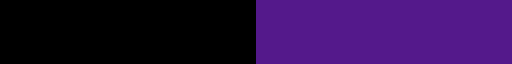

In [12]:
cmap = ListedColormap(np.array([[[0.0, 0.0, 0.0]], [[0.33333333, 0.10196078, 0.54509804]]]))
cmap

### Display

In [13]:
from matplotlib import pyplot as plt

In [14]:
def display(img, cmap):
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap=cmap)

### Create features image

In [15]:
hsi_reshaped = hsi.reshape(-1, hsi.shape[-1])
lidar_reshaped = lidar.reshape(-1)
hsi_reshaped.shape, lidar_reshaped.shape

((664845, 144), (664845,))

In [16]:
img_features = np.hstack((hsi_reshaped, lidar_reshaped.reshape(-1, 1)))
img_features.shape

(664845, 145)

### Predict

In [17]:
y_pred = model.predict(img_features)
img_pred = y_pred.reshape(lidar.shape)

### Visualize

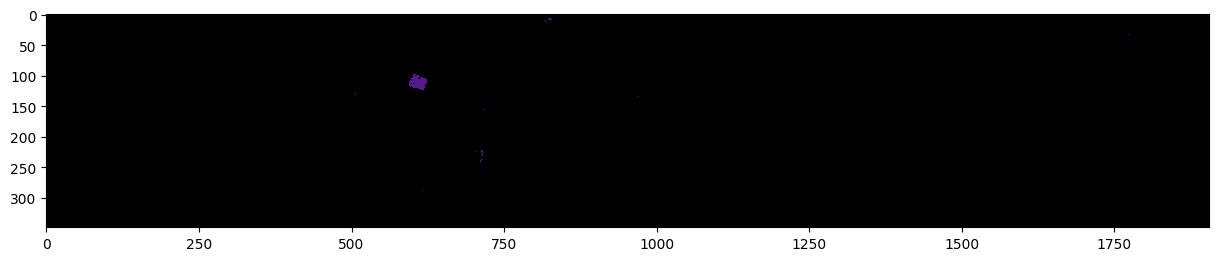

In [18]:
display(img_pred, cmap)

There is some noise and the main component has gaps. This can be easily fixed with open and close.

### Postprocessing

In [19]:
from skimage.morphology import closing, opening, square
from skimage.measure import label, regionprops

In [20]:
img_pred_pp = opening(closing(img_pred, square(3)))

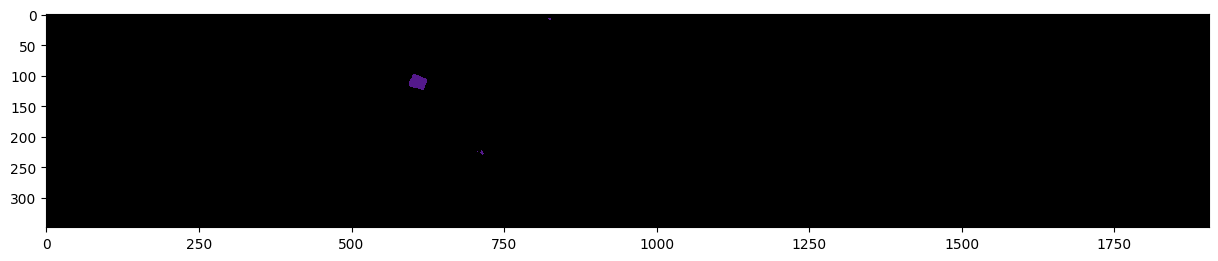

In [21]:
display(img_pred_pp, cmap=cmap)

There is still some noise. Let's keep only the groups having an area greater than 256.

In [22]:
img_pred_pp = label(img_pred_pp)
props = regionprops(img_pred_pp)

In [23]:
AREA_THRESHOLD = 128

for prop in props:
    if prop.area < AREA_THRESHOLD:
        img_pred_pp[img_pred_pp == prop.label] = Classes.UNKNOWN

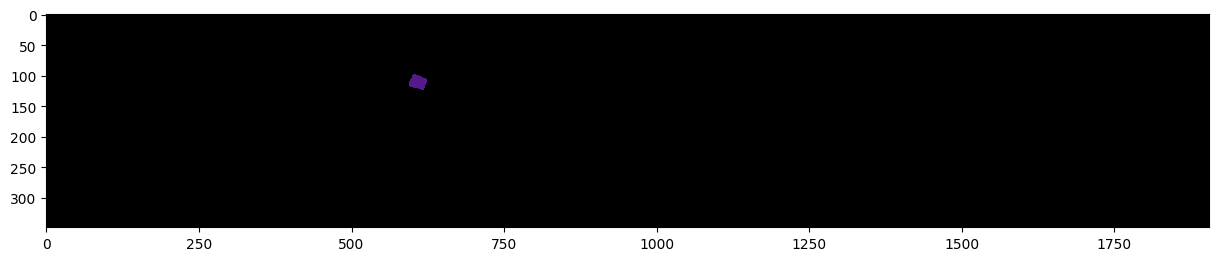

In [24]:
display(img_pred_pp, cmap)

Much better.

### Solution

In [27]:
from utils import load
from skimage.morphology import closing, opening, square
from skimage.measure import label, regionprops


def tennis_track_discriminate(hsi, lidar, area_threshold=128):
    hsi_reshaped = hsi.reshape(-1, hsi.shape[-1])
    lidar_reshaped = lidar.reshape(-1, 1)
    img_features = np.hstack((hsi_reshaped, lidar_reshaped))
    model = load("tennis_court_discriminator")
    y_pred = model.predict(img_features)
    img_pred = y_pred.reshape(hsi.shape[:-1])
    img_pred = closing(img_pred, square(3))
    img_pred = opening(img_pred)
    img_pred = label(img_pred)
    for prop in regionprops(img_pred):
        if prop.area < area_threshold:
            img_pred[img_pred == prop.label] = Classes.UNKNOWN
    img_pred[img_pred != Classes.UNKNOWN] = 1
    return img_pred

In [28]:
img_pred = tennis_track_discriminate(hsi, lidar)

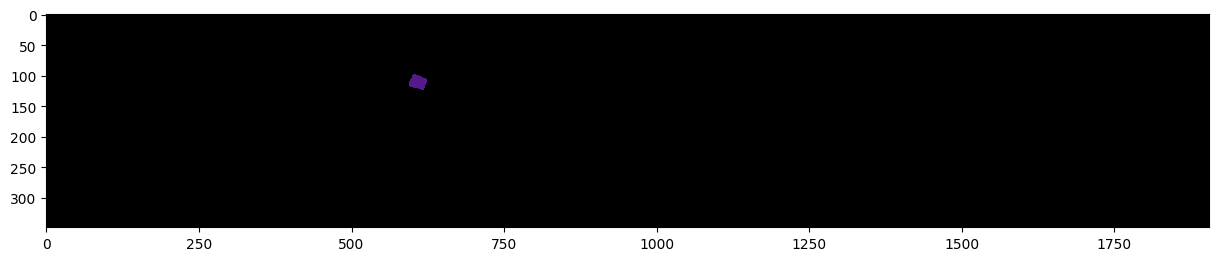

In [29]:
display(img_pred, cmap)